# Running large statistics
**WARNING**: This exercise requires a larger data sample than the one available with the git repository. Please download beforehand the complete **Full_DataSample** directory from the course sharepoint (including data and MC).

As we have seen at the end of the previous notebook, improving the statistical uncertainty on the measurement will require running the analysis on a larger statistics. If you inspect the directory containing the full data and MC statistics, you will see that we have almost 20 GB. And this is a much reduced dataset:
  - The data format for each event has been very simplified with respect to what is available for complete analysis
  - A lot of data has been removed from each event, especially what concerns the pile up
  - The samples presented to you have passed a rather strict pre-selection
  - The data sample available to you is only about 1/5 of the full 2022 dataset (and NA62 has been collecting data since 2015)
In total the data sample for NA62 correspond to several PB/year, so you see that 20 GB has indeed been seriously reduced. Nevertheless, if you were to try to load the complete dataset available to you in the DataFrames for analysis, you will find that this will probably not work as a pandas DataFrame is entirely loaded in the memory of your computer. You generally have only 8 GB of memory available, on some specialised computers and very powerful servers this can rise from 16 GB to 64 GB. While this may be enough for this dataset, it will certainly not be enough for the full NA62 dataset.

The way to go forward is to analyze the data in chunks: we load a chunk of some reasonable size (e.g. 1 GB), we run the data through our analysis function and produce some summarized "combinable" results, then we go on and do the same on all the remaining chunks. Once the process is over, we have N sets of summarized "combinable" results. We only have to combine these results together to obtain the final one. I highlighted the "combinable" keyword here, by which I mean that the results can easily be merged together. Essentially:
 - Numbers that can be summed or multiplied
 - Arrays that can be summed or concatenated

There are some standard packages that can perform this for us, one of them is Dask but it requires a bit of setup, configuration and infrastructure which is beyond the purpose of this exercises. It however has the nice feature to allow you to interact with your data as if you were manipulating pandas dataframes, hiding the complexities of the processing or the size of the data. Instead for this exercise which is not overly complex, we are going to run this through some custom functions that will do the job.

Technically we will define all the analysis functions we need. Each function will take a parameter containing the input dataframe. The output of our function will be a structure containing a possible output dataframe (in case the function is a *selection* function, maybe a list of histograms that we prepared, maybe some numbers that were computed from the dataframe, ... We will call a function which takes our list of function as parameter as well as the lists of all the input files. The function will take care of reading this files chunk by chunk, passing the chunks to the analysis functions and retrieve the results. The results will be merged for each chunk. This may take a little while to run over all the chunks, but in the output we will recover the final merged result for each of the sample we passed (data and each MC sample). We can then combine those to produce the inal result and display the plots that were prepared.

In [1]:
# Lets first import all we need
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from functools import partial
from na62 import prepare, hlf, extract, constants, stats, histo, processing

/home/nlurkin/jupyter/NA62_UCL/na62/processing.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Then we will take back some code from the previous notebook, without modifications.

In [2]:
### First the list of cuts

# Select the correct topology
cond_1T2C = hlf.make_exists_cut(["track1", "cluster1", "cluster2"], [])

# Distance/position cuts
lkr_dtrack_cluster_cond = partial(hlf.make_lkr_distance_cut, 150, None)
lkr_dclusters_cond = hlf.make_lkr_distance_cut(200, None, "cluster1", "cluster2")
z_vertex_cond = hlf.make_z_vertex_cut(120000, 180000)
cda_cond = hlf.make_cda_cut(None, 25)
neutral_vtx_cond = hlf.make_charged_neutral_vertex_cut(None, 10000, "cluster1", "cluster2", constants.pion_neutral_mass)

# Energy/momentum cuts
cluster_energy_cond = partial(hlf.make_energy_cut, 2000, None)

# PID cuts
rich_e_cond = partial(hlf.make_rich_cut, constants.rich_hypothesis_map["e"])
rich_pi_cond = partial(hlf.make_rich_cut, constants.rich_hypothesis_map["pi"])
rich_mu_cond = partial(hlf.make_rich_cut, constants.rich_hypothesis_map["mu"])
lkr_e_cond = partial(hlf.make_eop_cut, 0.95, 1.05)
lkr_pi_cond = partial(hlf.make_eop_cut, None, 0.9)
lkr_mu_cond = partial(hlf.make_eop_cut, None, 0.2)
muv3_mu_cond = partial(hlf.make_muv3_cut, True, time_window=1.5)
muv3_not_mu_cond = partial(hlf.make_muv3_cut, False, time_window=2.5)

# Define K2pi reconstructed kinematic cuts
k2pi_mass_assignment = {"track1": constants.pion_charged_mass, "cluster1": constants.photon_mass, "cluster2": constants.photon_mass}
k2pi_mmiss2_cond = hlf.make_missing_mass_sqr_cut(min_mm2=None, max_mm2=0.015*1e6, mass_assignments=k2pi_mass_assignment) # In GeV
k2pi_inv_mass_cond = hlf.make_invariant_mass_cut(min_mass=460, max_mass=520, mass_assignments=k2pi_mass_assignment)

# Let's define our specifc Ke3 selection
ke3_mass_assignment = {"track1": constants.electron_mass, "cluster1": constants.photon_mass, "cluster2": constants.photon_mass}
ke3_mmiss2_cond = hlf.make_missing_mass_sqr_cut(min_mm2=None, max_mm2=0.01*1e6, mass_assignments=ke3_mass_assignment) # In GeV
ptot_neutrino_cond = hlf.make_total_momentum_cut(15000, 70000)
pt_neutrino_cond = hlf.make_transverse_momentum_cut(40, 250)

In [3]:
# The selections definitions
common_1track_2cluster_selection = [cond_1T2C, z_vertex_cond, 
                                    lkr_dtrack_cluster_cond("track1", "cluster1"), lkr_dtrack_cluster_cond("track1", "cluster2"), lkr_dclusters_cond, 
                                    cluster_energy_cond("cluster1"), cluster_energy_cond("cluster2"), 
                                    cda_cond, neutral_vtx_cond]

k2pi_selection = [lkr_pi_cond(which_track="track1"), muv3_not_mu_cond(which_track="track1"), rich_pi_cond(which_track="track1"), 
                  k2pi_mmiss2_cond, k2pi_inv_mass_cond]


  
ke3_selection = [lkr_e_cond(which_track="track1"), # No other PID conditions necessary here, E/p is very good for electrons
                 ptot_neutrino_cond, pt_neutrino_cond, ke3_mmiss2_cond]

In [4]:
# The "compute" functions generating the final results
from uncertainties import ufloat
def compute_normalization(selected_data, selected_mc, br, mc_normalization):
    n_mc_sel = selected_mc if isinstance(selected_mc, int) else len(selected_mc)
    n_data_sel = selected_data if isinstance(selected_data, int) else len(selected_data)
    
    # Add poisson uncertainties 
    n_mc_sel = ufloat(n_mc_sel, np.sqrt(n_mc_sel), "MC K2pi")
    n_data_sel = ufloat(n_data_sel, np.sqrt(n_data_sel), "Data K2pi")
    
    # No uncertainty on the normalization: we know exactly how many MC events were generated for this sample
    acc = n_mc_sel/mc_normalization
    n_K = n_data_sel/(acc * br * 1.0)

    return acc, n_data_sel, n_K

def compute_signal_br(selected_data, selected_mc, mc_normalization, flux):
    n_mc_sel = selected_mc if isinstance(selected_mc, int) else len(selected_mc)
    n_data_sel = selected_data if isinstance(selected_data, int) else len(selected_data)

    # Add poisson uncertainties
    n_mc_sel = ufloat(n_mc_sel, np.sqrt(n_mc_sel), "MC Ke3")
    n_data_sel = ufloat(n_data_sel, np.sqrt(n_data_sel), "Data Ke3")

    # Rather than computing each ratio separately, we use directly the flux which include all 
    # the relevant K2pi values (so we don't have to pass all the values individually to the function)
    acc = n_mc_sel/mc_normalization
    br_ke3_meas = n_data_sel / (acc * 1. * flux)

    return acc, n_data_sel, br_ke3_meas

In [5]:
# Slight adaptation of the plot_before_cut function: use alternative histogramming functions compatible with the chunking functions

from typing import Union, List, Dict, Callable, Tuple
# Create a function that will apply all the cuts to the data and MC, except a cut we want to check,
# then plot the relevant distribution
def plot_before_cut(df: pd.DataFrame, isMC: bool,
                    selection: List[Callable], cut: Union[Callable, str], 
                    transform: Union[Callable, str], 
                    bins: int = 100, range: Union[None, Tuple[int, int]] = None) -> None:
    # Cut can be either the cut function we want to remove, or the name of the cut function
    # Example: z_vertex_cond = make_z_vertex_cut(105000, 180000)
    #   - Call with cut=z_vertex_cond
    #   - Or call with cut='z_vertex_cut'
    # Transform indicates which/how the plotted value should be extracted from the dataframe
    
    truncated_selection = hlf.remove_cut(selection, cut)

    # Perform truncated selection on data and MC
    d = hlf.select(df, truncated_selection)

    # Two cases: transform is a string and should correspond to a column of the dataframe, or a callable to be applied to the dataframe
    if isinstance(transform, str):
        # Transform it into a callable so we do not have to distinguish later
        col_name = transform
        transform = lambda df: df[col_name]
        
    if isMC:
        histo_function = histo.prepare_for_stack_flux
    else:
        histo_function = histo.prepare_hist_data
    return histo_function(transform(d), bins=bins, range=range)

In [6]:
# Similarly for the function for systematic checks, we just need to run all the variationd and record the number of selected events for each
from tqdm.autonotebook import tqdm

def systematic_checks(df: pd.DataFrame, normalization_selection: List[Callable], signal_selection: List[Callable], 
                      test_cut: Union[Callable, str], replacement_cuts: List[Callable], truncate_which: str = "both") -> Tuple[float]:

    # Truncate the selections if necessary
    truncated_norm_selection = hlf.remove_cut(normalization_selection, test_cut) if truncate_which in ["both", "norm"] else normalization_selection
    truncated_signal_selection = hlf.remove_cut(signal_selection, test_cut) if truncate_which in ["both", "signal"] else signal_selectionl

    # Prepare lists for output
    n_norm_selected = []
    n_signal_selected = []

    # Loop over the alternative cuts
    for new_cond in tqdm(replacement_cuts, desc="Systematics", leave=False):
        # Perform the alternative selection
        norm_selection = truncated_norm_selection + [new_cond] if truncate_which in ["both", "norm"] else truncated_norm_selection
        signal_selection = truncated_signal_selection + [new_cond] if truncate_which in ["both", "signal"] else truncated_signal_selection
        data_test_norm = hlf.select(df, norm_selection)
        data_test_signal = hlf.select(df, signal_selection)

        # Populate the output lists
        n_norm_selected.append(len(data_test_norm))
        n_signal_selected.append(len(data_test_signal))

    return n_norm_selected, n_signal_selected

Now the important part here is to define the various functions that will run the analysis. Each function will take as input a dictionary of AnalysisObject (see documentation for list of available variables), and output a new AnalysisObject instance. They keys of the dictionary indicate which analysis function generated the AnalysisObject, with the exception of "origin" which indicates the AnalysisObject containing the original dataframes, just fresh from the input file. The function will also receive a parameter "isMC" which indicates whether the dataframe we are working on is a MC dataframe or a Data dataframe (we may want to do something different for MC).

The code inside the analysis functions is once again taken mostly from the previous notebook, with little modifications to make it suitable to this generic processing.

In [7]:
def common_selection(input, isMC):
    output = processing.AnalysisObject("common_selection")
    
    # Take the origin dataframe
    df = input["origin"].df
    # Select first common 1-track & 2-clusters sample so we can use it multiple times without re-selecting it
    df_1T2C = hlf.select(df, common_1track_2cluster_selection)

    # Set the new dataframe to our output object because it will be used by other analysis function
    output.df = df_1T2C

    return output


def k2pi_normalization_selection(input, isMC):
    output = processing.AnalysisObject("k2pi_normalization")
    
    # Select the output dataframe from the common_selection function and run the k2pi selection
    df_1T2C = input["common_selection"].df
    df_k2pi = hlf.select(df_1T2C, k2pi_selection)

    # Prepare some histograms
    if isMC:
        histo_function = histo.stack_mc_scale
    else:
        histo_function = histo.hist_data

    output.histograms.append(histo_function(hlf.invariant_mass(df_1T2C, k2pi_mass_assignment), bins=400, range=(200,600)))
    output.histograms.append(histo_function(hlf.invariant_mass(df_k2pi, k2pi_mass_assignment), bins=400, range=(200,600)))

    # Record the number of selected events. We don't need the full dataframe from this analysis function
    output.numbers["n_k2pi_sel"] = len(df_k2pi)

    return output

def ke3_signal_selection(input, isMC):
    output = processing.AnalysisObject("ke3_signal")
    
    # Select the output dataframe from the common_selection function and run the ke3 selection
    df_1T2C = input["common_selection"].df
    df_ke3 = hlf.select(df_1T2C, ke3_selection)

    # Prepare some histograms
    if isMC:
        histo_function = histo.prepare_for_stack_flux
    else:
        histo_function = histo.hist_data

    output.histograms.append(histo_function(hlf.missing_mass_sqr(df_ke3, ke3_mass_assignment), bins=100, range=(-50000, 100000)))
    output.histograms.append(plot_before_cut(df_1T2C, isMC, ke3_selection, "eop_cut", "track1_eop", range=(0,1.5)))
    output.histograms.append(plot_before_cut(df_1T2C, isMC, ke3_selection, ptot_neutrino_cond, hlf.total_momentum, range=(0,80000)))
    output.histograms.append(plot_before_cut(df_1T2C, isMC, ke3_selection, pt_neutrino_cond, hlf.transverse_momentum_beam, range=(0,250)))
    output.histograms.append(plot_before_cut(df_1T2C, isMC, ke3_selection, ke3_mmiss2_cond, partial(hlf.missing_mass_sqr, momenta_or_masses=ke3_mass_assignment), range=(-20000,20000)))

    # Record the number of selected events. We don't need the full dataframe from this analysis function
    output.numbers["n_ke3_sel"] = len(df_ke3)

    return output

def common_cuts_checks(input, isMC):
    output = processing.AnalysisObject("common_cuts_checks")

    # Select the original dataframe
    df_orig = input["origin"].df

    output.histograms.append(plot_before_cut(df_orig, isMC, common_1track_2cluster_selection, z_vertex_cond, "vtx_z", range=(100000, 180000)))
    output.histograms.append(plot_before_cut(df_orig, isMC, common_1track_2cluster_selection, "lkr_distance_cut", 
                                             partial(hlf.lkr_distance, object_1="track1", object_2="cluster1"), range=(0, 3500)))
    output.histograms.append(plot_before_cut(df_orig, isMC, common_1track_2cluster_selection, "lkr_distance_cut", 
                                             partial(hlf.lkr_distance, object_1="track1", object_2="cluster2"), range=(0, 3500)))
    output.histograms.append(plot_before_cut(df_orig, isMC, common_1track_2cluster_selection, "lkr_distance_cut", 
                                             partial(hlf.lkr_distance, object_1="cluster1", object_2="cluster2"), range=(0, 2000)))
    output.histograms.append(plot_before_cut(df_orig, isMC, common_1track_2cluster_selection, "energy_cut", "cluster1_lkr_energy", range=(0, 60000)))
    output.histograms.append(plot_before_cut(df_orig, isMC, common_1track_2cluster_selection, "energy_cut", "cluster2_lkr_energy", range=(0, 60000)))
    output.histograms.append(plot_before_cut(df_orig, isMC, common_1track_2cluster_selection, cda_cond, hlf.beam_vertex_cda, range=(0,20)))
    output.histograms.append(plot_before_cut(df_orig, isMC, common_1track_2cluster_selection, neutral_vtx_cond, 
                                             partial(hlf.charged_neutral_distance, cluster_1="cluster1", cluster_2="cluster2", clusters_invariant_mass=constants.pion_neutral_mass), range=(0,250000)))

    return output

def perform_systematic_checks(input, isMC):
    output = processing.AnalysisObject("systematics_checks")

    # Select the original dataframe
    df_orig = input["origin"].df

    # CDA check
    cda_values = list(np.arange(15, 40+5, 5))
    replacement_cuts = [hlf.make_cda_cut(None, cda_value) for cda_value in cda_values]
    n_norm_selected, n_signal_selected = systematic_checks(df_orig, common_1track_2cluster_selection + k2pi_selection, common_1track_2cluster_selection + ke3_selection, 
                                                           cda_cond, replacement_cuts)
    output.numbers["CDA_norm"] = np.array(n_norm_selected)
    output.numbers["CDA_signal"] = np.array(n_signal_selected)

    # E/p lower edge check
    eop_values = list(np.arange(0.90, 0.97+0.01, 0.01))
    replacement_cuts = [hlf.make_eop_cut(eop_value, 1.05, which_track="track1") for eop_value in eop_values]
    n_norm_selected, n_signal_selected = systematic_checks(df_orig, common_1track_2cluster_selection + k2pi_selection, common_1track_2cluster_selection + ke3_selection, 
                                                           ke3_selection[0], replacement_cuts, truncate_which="signal")
    output.numbers["EoP_Low_norm"] = np.array(n_norm_selected)
    output.numbers["EoP_Low_signal"] = np.array(n_signal_selected)

    # E/p upper edge check
    eop_values = list(np.arange(1.03, 1.10+0.01, 0.01))
    replacement_cuts = [hlf.make_eop_cut(0.95, eop_value, which_track="track1") for eop_value in eop_values]
    n_norm_selected, n_signal_selected = systematic_checks(df_orig, common_1track_2cluster_selection + k2pi_selection, common_1track_2cluster_selection + ke3_selection, 
                                                           ke3_selection[0], replacement_cuts, truncate_which="signal")
    output.numbers["EoP_High_norm"] = np.array(n_norm_selected)
    output.numbers["EoP_High_signal"] = np.array(n_signal_selected)

    return output

We are now ready to run our analysis on a large sample of data. Let's retrieve the list of files for the full statistics and pass that to the "run_complete_analysis" wrapper. This may take some time to complete.

In [8]:
from pathlib import Path
def list_root_files(path):
    return sorted(Path(path).glob("*.root"))

# The next two lines will load the standard files provides in the repository (to compare 1-to-1 results with previous notebook)
datafiles = ["data/run12450.root"]
mc_files_dict = {"k2pi": ["data/k2pi.root"], "k3pi": ["data/k3pi.root"], "kmu2": ["data/kmu2.root"], "kmu3": ["data/kmu3.root"], "ke3": ["data/ke3.root"]}

# The next few lines instead will use the full statistics available - toggle the switch if you want to run it
run_large_stats = False
if run_large_stats:
    datafiles = list_root_files("Full_DataSample/2022D")
    mc_files_dict = {"k2pi": list_root_files("Full_DataSample/K2pi/"), "k3pi": list_root_files("Full_DataSample/K3pi/"), 
                     "kmu2": list_root_files("Full_DataSample/Kmu2/"), "kmu3": list_root_files("Full_DataSample/Kmu3/"),
                     "ke3": list_root_files("Full_DataSample/Ke3/")}

# Chunk size tuned to reach a memory usage of ~8GB. Takes about 30 minutes per chunk. Modify according to availability on your system
chunk_size = 5000000
# We will run in chunks of 1 million events. That should fit nicely in the memory of our computer
data_result, mc_results = processing.run_complete_analysis(datafiles, mc_files_dict, 
                                                           [common_selection, common_cuts_checks, k2pi_normalization_selection, ke3_signal_selection, perform_systematic_checks], 
                                                           chunk_size=chunk_size)

Data files processed:   0%|          | 0/1 [00:00<?, ?it/s]

Systematics:   0%|          | 0/6 [00:00<?, ?it/s]

Systematics:   0%|          | 0/8 [00:00<?, ?it/s]

Systematics:   0%|          | 0/9 [00:00<?, ?it/s]

k2pi files processed:   0%|          | 0/1 [00:00<?, ?it/s]

Systematics:   0%|          | 0/6 [00:00<?, ?it/s]

Systematics:   0%|          | 0/8 [00:00<?, ?it/s]

Systematics:   0%|          | 0/9 [00:00<?, ?it/s]

k3pi files processed:   0%|          | 0/1 [00:00<?, ?it/s]

Systematics:   0%|          | 0/6 [00:00<?, ?it/s]

Systematics:   0%|          | 0/8 [00:00<?, ?it/s]

Systematics:   0%|          | 0/9 [00:00<?, ?it/s]

kmu2 files processed:   0%|          | 0/1 [00:00<?, ?it/s]

Systematics:   0%|          | 0/6 [00:00<?, ?it/s]

Systematics:   0%|          | 0/8 [00:00<?, ?it/s]

Systematics:   0%|          | 0/9 [00:00<?, ?it/s]

kmu3 files processed:   0%|          | 0/1 [00:00<?, ?it/s]

Systematics:   0%|          | 0/6 [00:00<?, ?it/s]

Systematics:   0%|          | 0/8 [00:00<?, ?it/s]

Systematics:   0%|          | 0/9 [00:00<?, ?it/s]

ke3 files processed:   0%|          | 0/1 [00:00<?, ?it/s]

Systematics:   0%|          | 0/6 [00:00<?, ?it/s]

Systematics:   0%|          | 0/8 [00:00<?, ?it/s]

Systematics:   0%|          | 0/9 [00:00<?, ?it/s]

Now that the analysis is complete, we can compute our final result as we did in the previous notebook.

In [9]:
# First let's compute some useful numbers
normalization_dict = {_: mc_results[_]["origin"].numbers["normalization"] for _ in mc_results}

In [10]:
# Then the final result (with uncertainties)

# Normalization
br_k2pi = ufloat(constants.kaon_br_map["k2pi"], 0.0008, "K2pi BR")
data_k2pi = data_result["k2pi_normalization"].numbers["n_k2pi_sel"]
mc_k2pi = mc_results["k2pi"]["k2pi_normalization"].numbers["n_k2pi_sel"]
normalization_k2pi = mc_results["k2pi"]["origin"].numbers["normalization"]
k2pi_acc, n_k2pi_data_sel, k2pi_N_K = compute_normalization(data_k2pi, mc_k2pi, br_k2pi, normalization_k2pi)

# Print normalization numbers
print(f"K2pi selection acceptance: {k2pi_acc:%}")
print(f"Number of K2pi candidates in data: {n_k2pi_data_sel} candidates")
print(f"Kaon flux: {k2pi_N_K:e} kaons")

# And the signal measurement
data_ke3 = data_result["ke3_signal"].numbers["n_ke3_sel"]
mc_ke3 = mc_results["ke3"]["ke3_signal"].numbers["n_ke3_sel"]
normalization_ke3 = mc_results["ke3"]["origin"].numbers["normalization"]
ke3_acc, n_ke3_data_sel, br_ke3_meas = compute_signal_br(data_ke3, mc_ke3, normalization_ke3, k2pi_N_K)
br_ke3 = ufloat(constants.kaon_br_map['ke3'], 0.0004)

# With the printing
print(f"Measured Ke3 branching ratio: {br_ke3_meas:%}")
print(f"Most precise Ke3 branching ratio (PDG): {br_ke3:%}")

K2pi selection acceptance: (9.077+/-0.021)%
Number of K2pi candidates in data: (1.912+/-0.014)e+04 candidates
Kaon flux: (1.019+/-0.009)e+06 kaons
Measured Ke3 branching ratio: (5.14+/-0.09)%
Most precise Ke3 branching ratio (PDG): (5.07+/-0.04)%


**TODO**: Conclude here

We can also plot the histogram that were prepared in the analysis functions to check the Data/MC agreement.

First for the normalization selection, with the Data scaling (resulting in not so good visuals)

K2pi selection purity: 35.44%


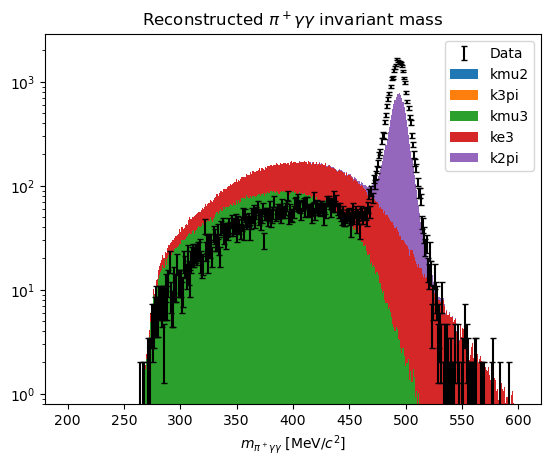

In [11]:
ndata, nmc = processing.plot_prepared_histo_scale(data_result, mc_results, "k2pi_normalization", 0)
plt.legend()
plt.yscale("log")
plt.ylim(bottom=0.8)
plt.title("Reconstructed $\pi^+\gamma\gamma$ invariant mass")
plt.xlabel("$m_{\pi^+\gamma\gamma}$ [MeV/$c^2$]")
print(f"K2pi selection purity: {nmc['k2pi']/sum(nmc.values()):.2%}")

K2pi selection purity: 100.00%


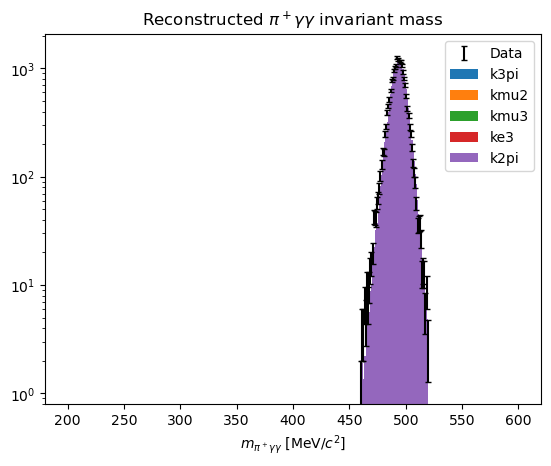

In [12]:
ndata, nmc = processing.plot_prepared_histo_scale(data_result, mc_results, "k2pi_normalization", 1)
plt.legend()
plt.yscale("log")
plt.ylim(bottom=0.8)
plt.title("Reconstructed $\pi^+\gamma\gamma$ invariant mass")
plt.xlabel("$m_{\pi^+\gamma\gamma}$ [MeV/$c^2$]")
print(f"K2pi selection purity: {nmc['k2pi']/sum(nmc.values()):.2%}")

Then we have the checks on the cuts from the common selection

Text(0.5, 1.0, 'Vertex Z distribution')

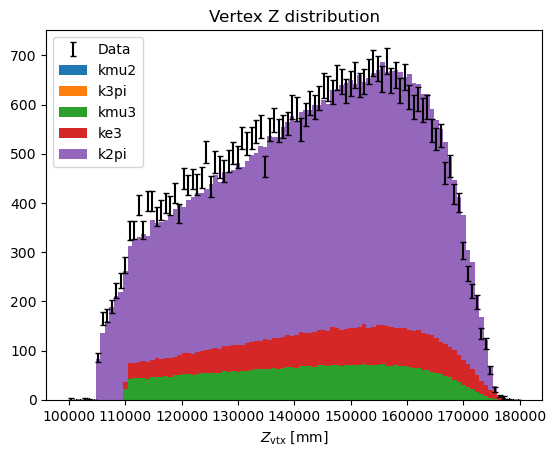

In [13]:
# Z vertex cut
processing.plot_prepared_histo_flux(data_result, mc_results, normalization_dict, "common_cuts_checks", k2pi_N_K.n, 0)
plt.xlabel("$Z_\mathrm{vtx}$ [mm]")
plt.legend()
plt.title("Vertex Z distribution")

Text(0.5, 0, '$d_\\mathrm{cluster,cluster}$ [mm]')

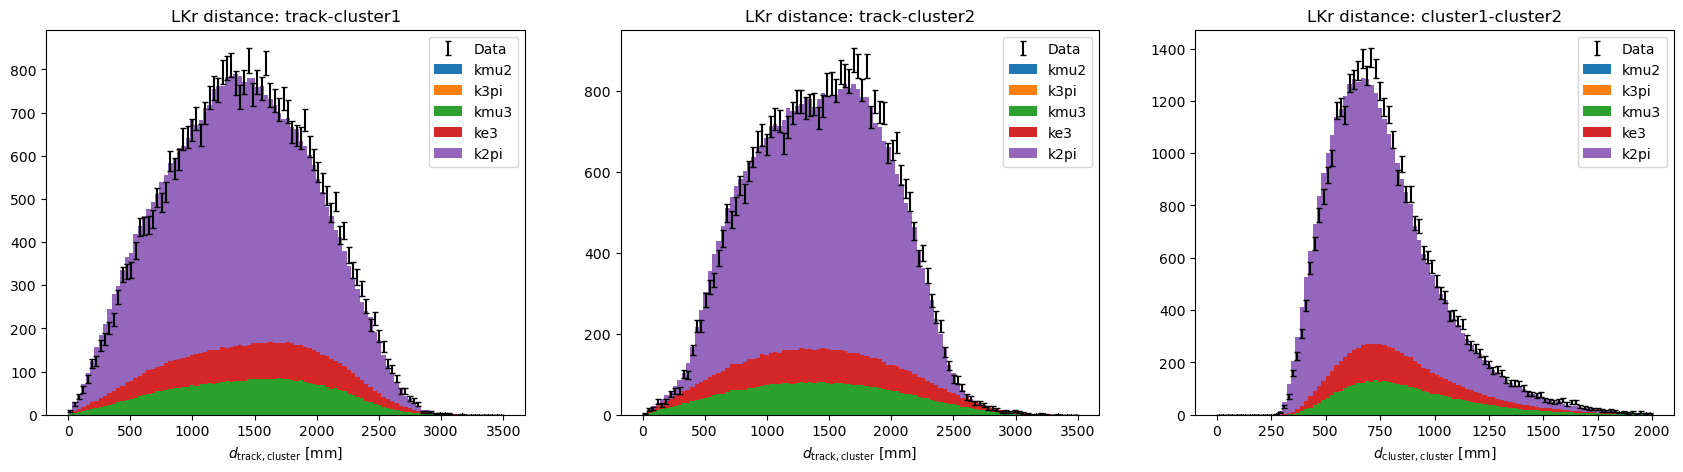

In [14]:
# LKr distance cut (3 different cuts: track-cl1, track-cl2, cl1-cl2)
fig, ax = plt.subplots(1, 3, figsize=(21, 5))
processing.plot_prepared_histo_flux(data_result, mc_results, normalization_dict, "common_cuts_checks", k2pi_N_K.n, 1, ax=ax[0])
ax[0].legend()
ax[0].set_title("LKr distance: track-cluster1")
ax[0].set_xlabel("$d_\mathrm{track,cluster}$ [mm]")

processing.plot_prepared_histo_flux(data_result, mc_results, normalization_dict, "common_cuts_checks", k2pi_N_K.n, 2, ax=ax[1])
ax[1].legend()
ax[1].set_title("LKr distance: track-cluster2")
ax[1].set_xlabel("$d_\mathrm{track,cluster}$ [mm]")

processing.plot_prepared_histo_flux(data_result, mc_results, normalization_dict, "common_cuts_checks", k2pi_N_K.n, 3, ax=ax[2])
ax[2].legend()
ax[2].set_title("LKr distance: cluster1-cluster2")
ax[2].set_xlabel("$d_\mathrm{cluster,cluster}$ [mm]")

Text(0.5, 0, 'E [MeV]')

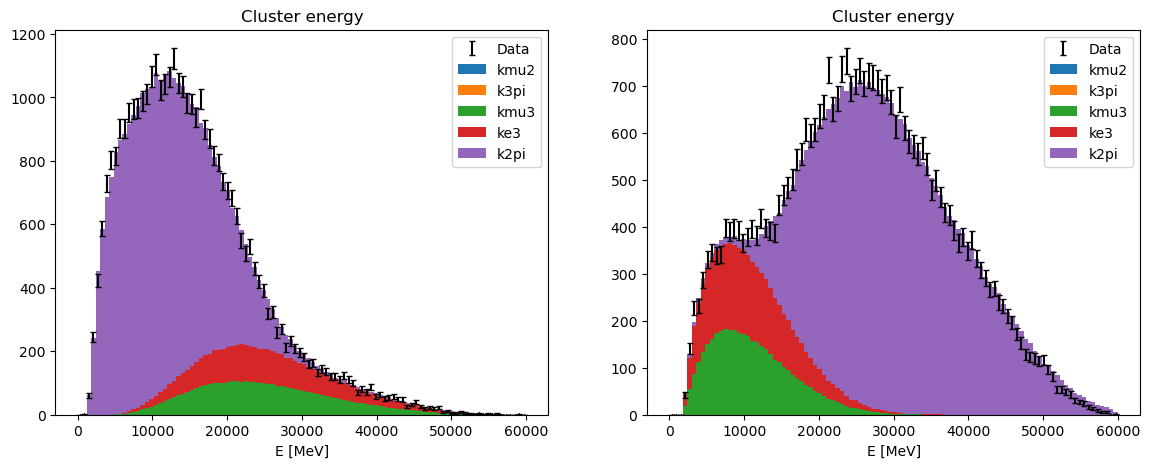

In [15]:
# Cluster energy cuts
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
processing.plot_prepared_histo_flux(data_result, mc_results, normalization_dict, "common_cuts_checks", k2pi_N_K.n, 4, ax=ax[0])
ax[0].legend()
ax[0].set_title("Cluster energy")
ax[0].set_xlabel("E [MeV]")

processing.plot_prepared_histo_flux(data_result, mc_results, normalization_dict, "common_cuts_checks", k2pi_N_K.n, 5, ax=ax[1])
ax[1].legend()
ax[1].set_title("Cluster energy")
ax[1].set_xlabel("E [MeV]")

Text(0.5, 1.0, 'CDA distribution')

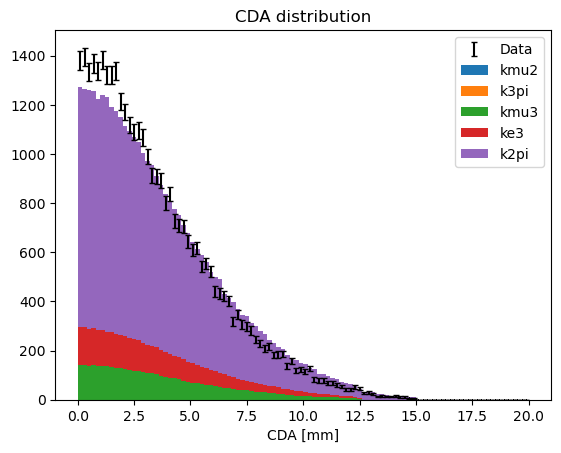

In [16]:
# CDA cut
processing.plot_prepared_histo_flux(data_result, mc_results, normalization_dict, "common_cuts_checks", k2pi_N_K.n, 6)
plt.xlabel("CDA [mm]")
plt.legend()
plt.title("CDA distribution")

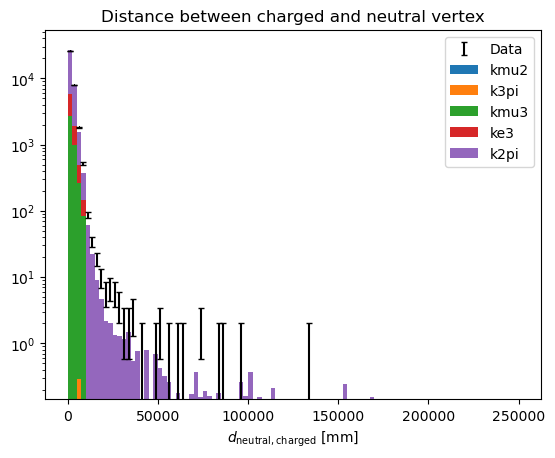

In [17]:
# Neutral vertex cut
processing.plot_prepared_histo_flux(data_result, mc_results, normalization_dict, "common_cuts_checks", k2pi_N_K.n, 7)
plt.xlabel("$d_\mathrm{neutral,charged}$ [mm]")
plt.legend()
plt.title("Distance between charged and neutral vertex")
plt.yscale("log")

And we complete with the Ke3 selection.

Ke3 selection pollution (1-purity): 1.80e-05
Ke3 selection acceptance: 7.40%


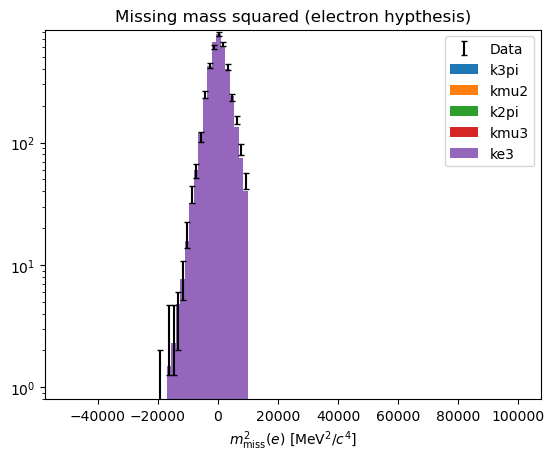

In [18]:
ndata, nmc = processing.plot_prepared_histo_flux(data_result, mc_results, normalization_dict, "ke3_signal", k2pi_N_K.n, 0)
plt.ylim(bottom=1e-2)
plt.title("Missing mass squared (electron hypthesis)")
plt.xlabel("$m_\mathrm{miss}^2(e)$ [$\mathrm{MeV}^{2}/c^{4}]$")
plt.yscale("log")
plt.ylim(bottom=0.8)
plt.legend()
print(f"Ke3 selection pollution (1-purity): {1-nmc['ke3']/sum(nmc.values()):.2e}")
print(f"Ke3 selection acceptance: {mc_results['ke3']['ke3_signal'].numbers['n_ke3_sel']/normalization_dict['ke3']:.2%}")

And the Ke3-specific cuts stability checks 

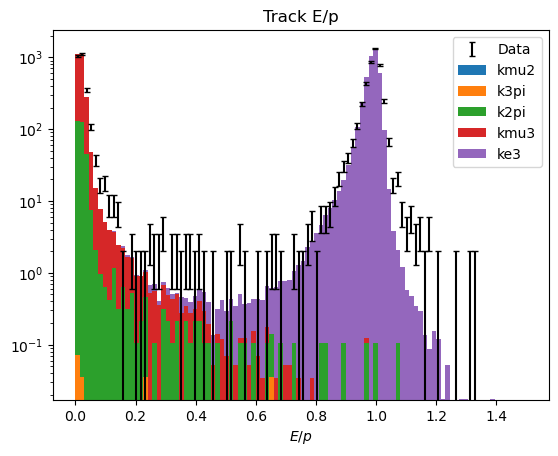

In [19]:
ndata, nmc = processing.plot_prepared_histo_flux(data_result, mc_results, normalization_dict, "ke3_signal", k2pi_N_K.n, 1)
plt.xlabel("$E/p$")
plt.legend()
plt.title("Track E/p")
plt.yscale("log")

Text(0.5, 1.0, 'Total reconstructed momentum')

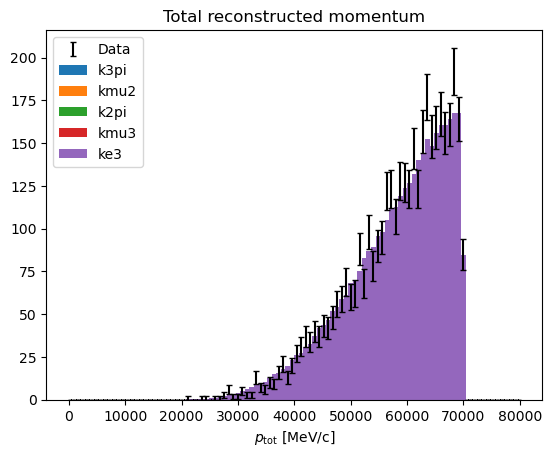

In [20]:
# Total momentum cut
ndata, nmc = processing.plot_prepared_histo_flux(data_result, mc_results, normalization_dict, "ke3_signal", k2pi_N_K.n, 2)
plt.xlabel("$p_\mathrm{tot}$ [MeV/c]")
plt.legend()
plt.title("Total reconstructed momentum")

Text(0.5, 1.0, 'Total transverse momentum with respect to Beam momentum')

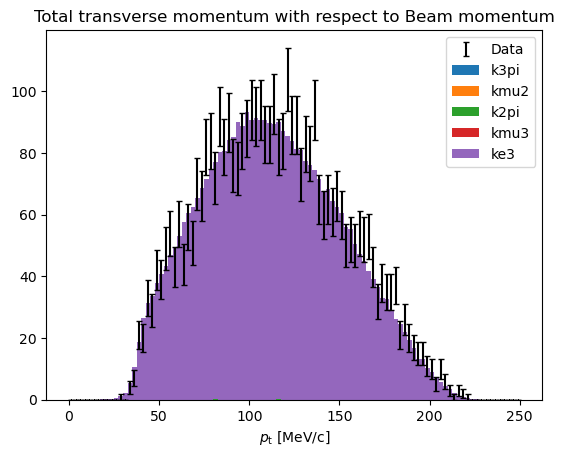

In [21]:
# Transverse momentum cut
ndata, nmc = processing.plot_prepared_histo_flux(data_result, mc_results, normalization_dict, "ke3_signal", k2pi_N_K.n, 3)
plt.xlabel("$p_\mathrm{t}$ [MeV/c]")
plt.legend()
plt.title("Total transverse momentum with respect to Beam momentum")

Text(0.5, 1.0, 'Missing mass squared (electron hypothesis)')

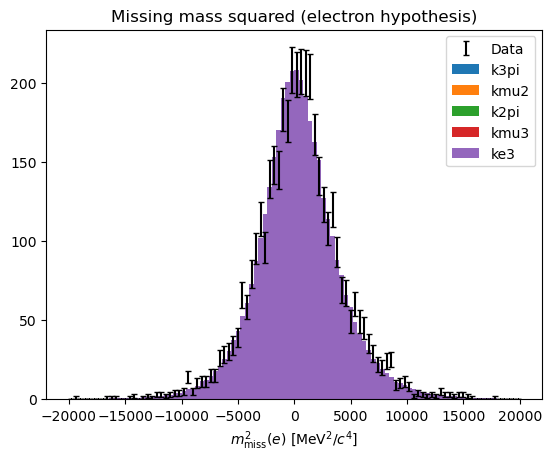

In [22]:
# Missing mass squared cut
ndata, nmc = processing.plot_prepared_histo_flux(data_result, mc_results, normalization_dict, "ke3_signal", k2pi_N_K.n, 4)
plt.xlabel("$m_\mathrm{miss}^2(e)$ [$\mathrm{MeV}^2/c^{4}$]")
plt.legend()
plt.title("Missing mass squared (electron hypothesis)")

And finally the systematic checks

In [23]:
def systematic_final(selected_data: List[float], selected_mc: List[float], name: str, br_norm: float, norm_name: str, signal_name: str) -> Tuple[float]:
    # Prepare lists for output
    flux_list = []
    n_norm_list = []
    acc_norm_list = []
    n_sig_list = []
    acc_sig_list = []
    br_sig_list = []

    # Loop over the alternative cuts
    for iTest in np.arange(len(selected_data[f"{name}_norm"])):
        data_test_norm = int(selected_data[f"{name}_norm"][iTest])
        mc_test_norm = int(selected_mc[norm_name][f"{name}_norm"][iTest])
        data_test_signal = int(selected_data[f"{name}_signal"][iTest])
        mc_test_signal = int(selected_mc[signal_name][f"{name}_signal"][iTest])

        # Compute the final numbers
        norm_acc, n_norm_data_sel, flux = compute_normalization(data_test_norm, mc_test_norm, br_norm, normalization_dict[norm_name])
        sig_acc, n_sig_data_sel, br_sig_meas = compute_signal_br(data_test_signal, mc_test_signal, normalization_dict[signal_name], flux)

        # Populate the output lists
        flux_list.append(flux)
        n_norm_list.append(n_norm_data_sel)
        acc_norm_list.append(norm_acc)
        n_sig_list.append(n_sig_data_sel)
        acc_sig_list.append(sig_acc)
        br_sig_list.append(br_sig_meas)

    return flux_list, n_norm_list, acc_norm_list, n_sig_list, acc_sig_list, br_sig_list

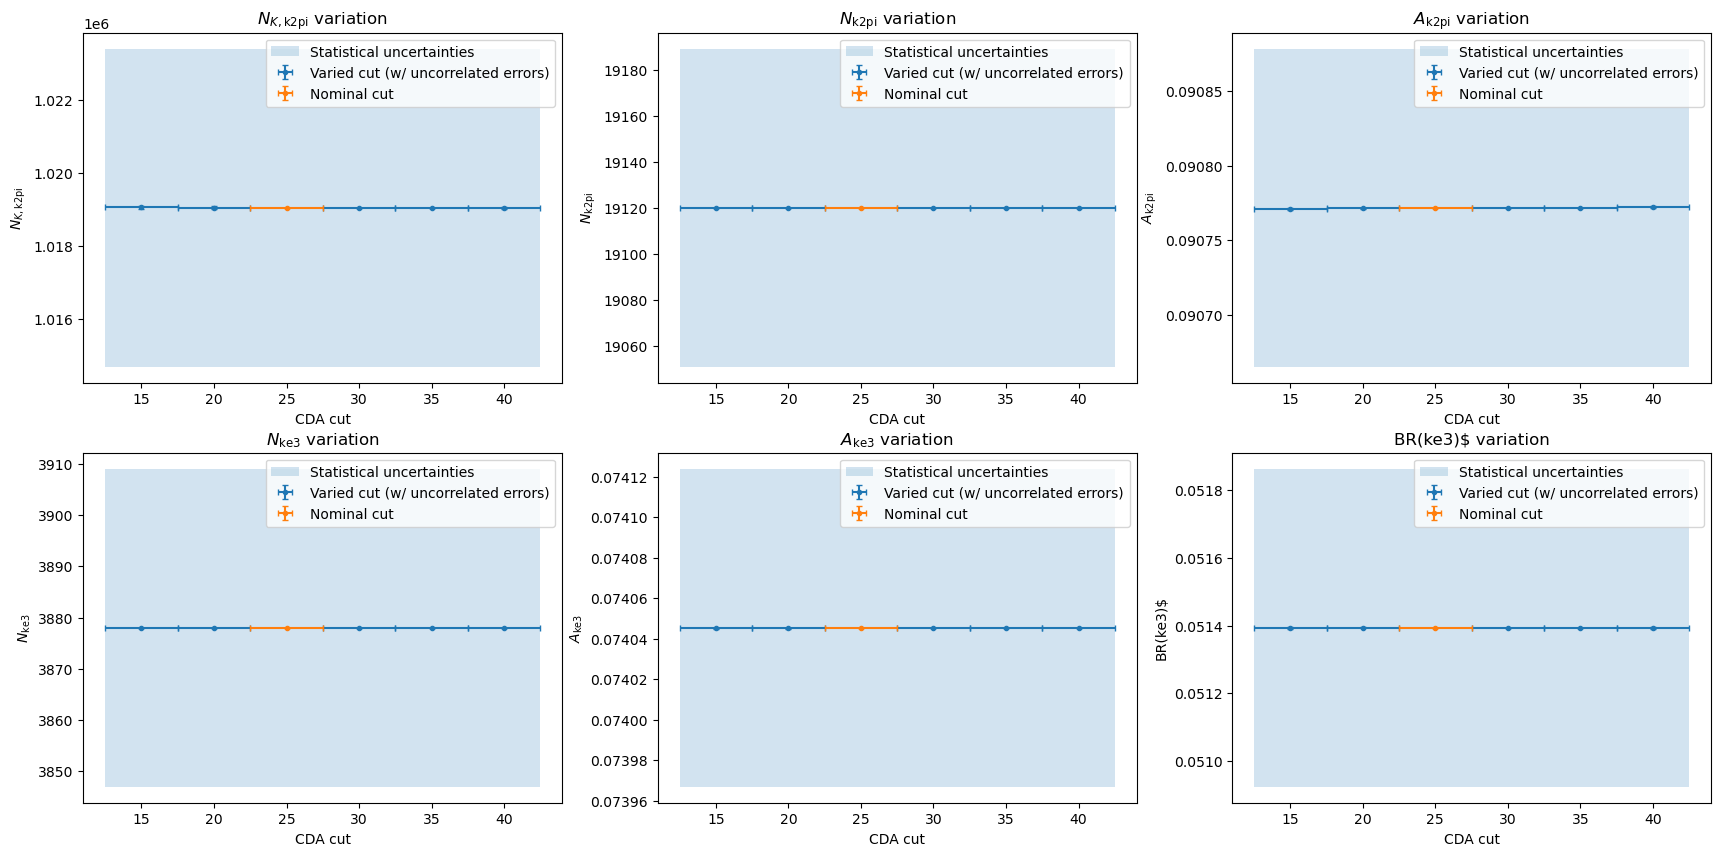

In [24]:
cda_values = list(np.arange(15, 40+5, 5))
flux_list, n_k2pi_list, acc_k2pi_list, n_ke3_list, acc_ke3_list, br_ke3_list = systematic_final(data_result["systematics_checks"].numbers, 
                                                                                                {sample: mc_results[sample]["systematics_checks"].numbers for sample in mc_results}, 
                                                                                                "CDA", br_k2pi, "k2pi", "ke3")
fig, ax = plt.subplots(2, 3, figsize=(21, 10))
histo.plot_variations(cda_values, flux_list, 2, "$N_{K,\mathrm{k2pi}}$", "CDA", ax[0][0])
histo.plot_variations(cda_values, n_k2pi_list, 2, "$N_\mathrm{k2pi}$", "CDA", ax[0][1])
histo.plot_variations(cda_values, acc_k2pi_list, 2, "$A_\mathrm{k2pi}$", "CDA", ax[0][2])

histo.plot_variations(cda_values, n_ke3_list, 2, "$N_\mathrm{ke3}$", "CDA", ax[1][0])
histo.plot_variations(cda_values, acc_ke3_list, 2, "$A_\mathrm{ke3}$", "CDA", ax[1][1])
histo.plot_variations(cda_values, br_ke3_list, 2, "BR(ke3)$", "CDA", ax[1][2])

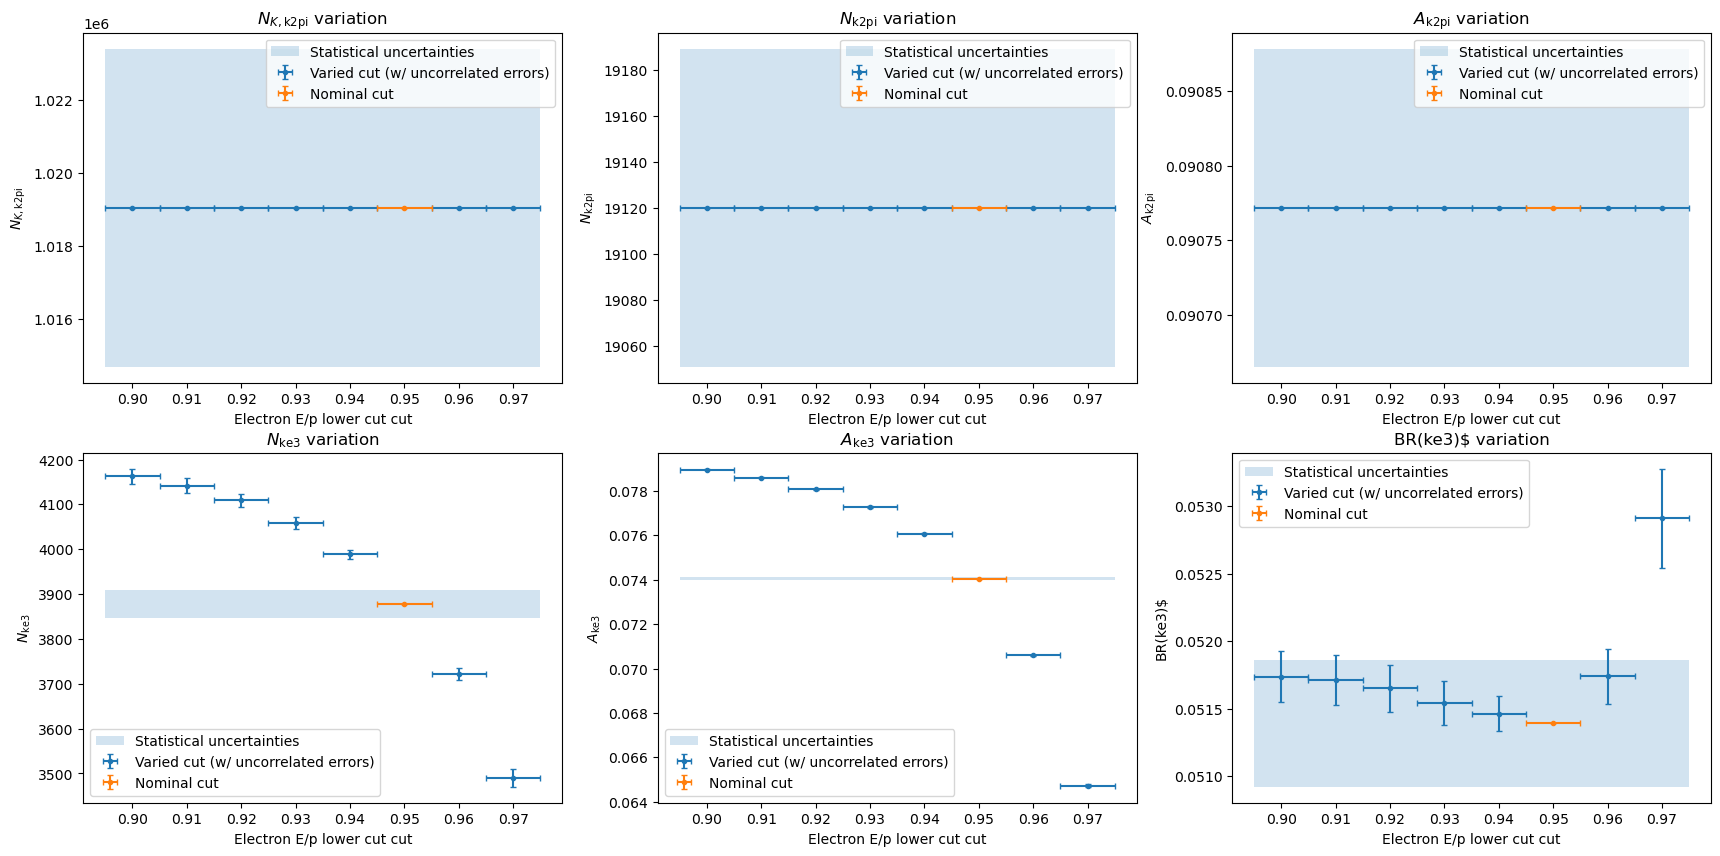

In [25]:
eop_values = list(np.arange(0.90, 0.97+0.01, 0.01))
flux_list, n_k2pi_list, acc_k2pi_list, n_ke3_list, acc_ke3_list, br_ke3_list = systematic_final(data_result["systematics_checks"].numbers, 
                                                                                                {sample: mc_results[sample]["systematics_checks"].numbers for sample in mc_results}, 
                                                                                                "EoP_Low", br_k2pi, "k2pi", "ke3")
fig, ax = plt.subplots(2, 3, figsize=(21, 10))
histo.plot_variations(eop_values, flux_list, 5, "$N_{K,\mathrm{k2pi}}$", "Electron E/p lower cut", ax[0][0])
histo.plot_variations(eop_values, n_k2pi_list, 5, "$N_\mathrm{k2pi}$", "Electron E/p lower cut", ax[0][1])
histo.plot_variations(eop_values, acc_k2pi_list, 5, "$A_\mathrm{k2pi}$", "Electron E/p lower cut", ax[0][2])

histo.plot_variations(eop_values, n_ke3_list, 5, "$N_\mathrm{ke3}$", "Electron E/p lower cut", ax[1][0])
histo.plot_variations(eop_values, acc_ke3_list, 5, "$A_\mathrm{ke3}$", "Electron E/p lower cut", ax[1][1])
histo.plot_variations(eop_values, br_ke3_list, 5, "BR(ke3)$", "Electron E/p lower cut", ax[1][2])

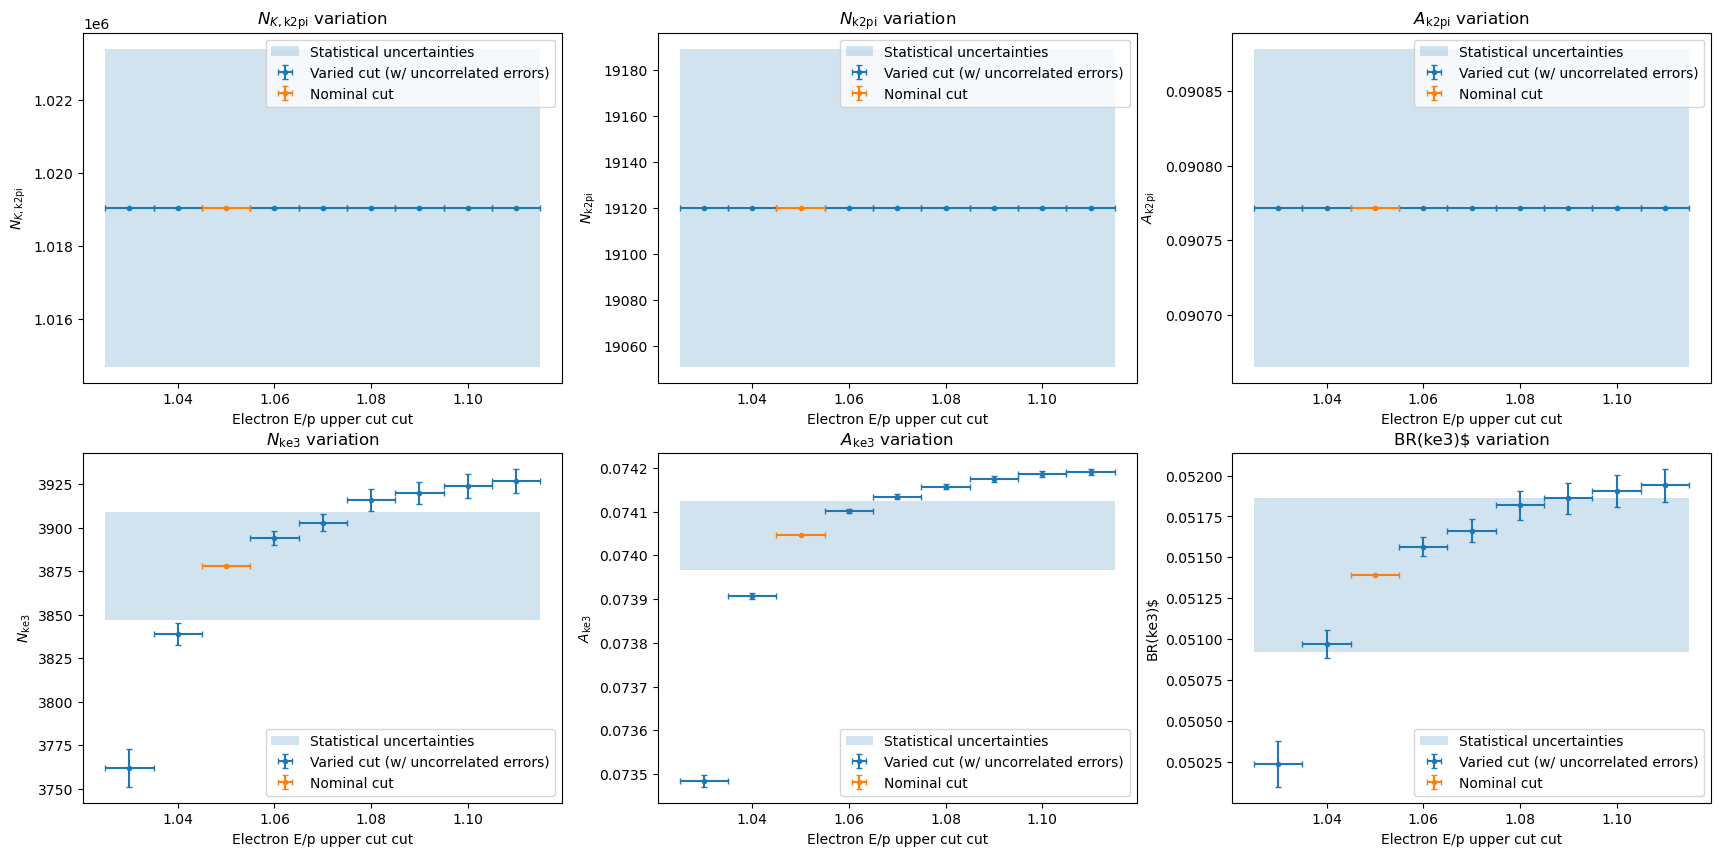

In [26]:
eop_values = list(np.arange(1.03, 1.10+0.01, 0.01))
flux_list, n_k2pi_list, acc_k2pi_list, n_ke3_list, acc_ke3_list, br_ke3_list = systematic_final(data_result["systematics_checks"].numbers, 
                                                                                                {sample: mc_results[sample]["systematics_checks"].numbers for sample in mc_results}, 
                                                                                                "EoP_High", br_k2pi, "k2pi", "ke3")
fig, ax = plt.subplots(2, 3, figsize=(21, 10))
histo.plot_variations(eop_values, flux_list, 2, "$N_{K,\mathrm{k2pi}}$", "Electron E/p upper cut", ax[0][0])
histo.plot_variations(eop_values, n_k2pi_list, 2, "$N_\mathrm{k2pi}$", "Electron E/p upper cut", ax[0][1])
histo.plot_variations(eop_values, acc_k2pi_list, 2, "$A_\mathrm{k2pi}$", "Electron E/p upper cut", ax[0][2])

histo.plot_variations(eop_values, n_ke3_list, 2, "$N_\mathrm{ke3}$", "Electron E/p upper cut", ax[1][0])
histo.plot_variations(eop_values, acc_ke3_list, 2, "$A_\mathrm{ke3}$", "Electron E/p upper cut", ax[1][1])
histo.plot_variations(eop_values, br_ke3_list, 2, "BR(ke3)$", "Electron E/p upper cut", ax[1][2])

In [27]:
# Ignore the first entry corresponding to the too tight cut
syst_br_list = br_ke3_list[1:]
# Compute the difference with the nominal value
diff = np.array(syst_br_list) - br_ke3_meas
# Take the largest difference
syst_error = max(diff).n

br_ke3_meas_wsyst = br_ke3_meas + ufloat(0, syst_error, "Systematic")
print(f"Systematic uncertainty assigned to the E/p cut: {syst_error:.0e}")
print(f"Final measurement with systematic uncertainties: {br_ke3_meas_wsyst:%}")
print(f"Most precise Ke3 branching ratio (PDG): {br_ke3:%}")

Systematic uncertainty assigned to the E/p cut: 5e-04
Final measurement with systematic uncertainties: (5.14+/-0.11)%
Most precise Ke3 branching ratio (PDG): (5.07+/-0.04)%


If you were running on the same files as in the previous notebook, you can notice that everything looks exactly the same: the final results, the stability checks, the uncertainties, the systematics. This proves that the processing by chunk works correctly.

If you ran on the full statistics:
**TODO** Condlude here